In [76]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df= pd.read_csv('https://raw.githubusercontent.com/dataprofessor/data/refs/heads/master/delaney_solubility_with_descriptors.csv')
df


,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


# ML MODEL

In [ ]:

class SolubilityDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


x = df.drop('logS', axis=1).values
y = df['logS'].values



In [82]:
# norm
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=100)

train_dataset = SolubilityDataset(x_train, y_train)
test_dataset = SolubilityDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# defining the model
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = RegressionNN()




In [ ]:
# training the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

Epoch 20/200, Loss: 0.3807
Epoch 40/200, Loss: 0.3854
Epoch 60/200, Loss: 0.3788
Epoch 80/200, Loss: 0.4066
Epoch 100/200, Loss: 0.3548
Epoch 120/200, Loss: 0.3525
Epoch 140/200, Loss: 0.3542
Epoch 160/200, Loss: 0.3288
Epoch 180/200, Loss: 0.3131
Epoch 200/200, Loss: 0.3044


Epoch 20/200, Loss: 0.2988
Epoch 40/200, Loss: 0.2981
Epoch 60/200, Loss: 0.3170
Epoch 80/200, Loss: 0.2718
Epoch 100/200, Loss: 0.2932
Epoch 120/200, Loss: 0.2556
Epoch 140/200, Loss: 0.2670
Epoch 160/200, Loss: 0.2529
Epoch 180/200, Loss: 0.2338
Epoch 200/200, Loss: 0.2494
resultados do modelo:
Test MSE: 0.7352240085601807
Test R² : 0.8481295704841614


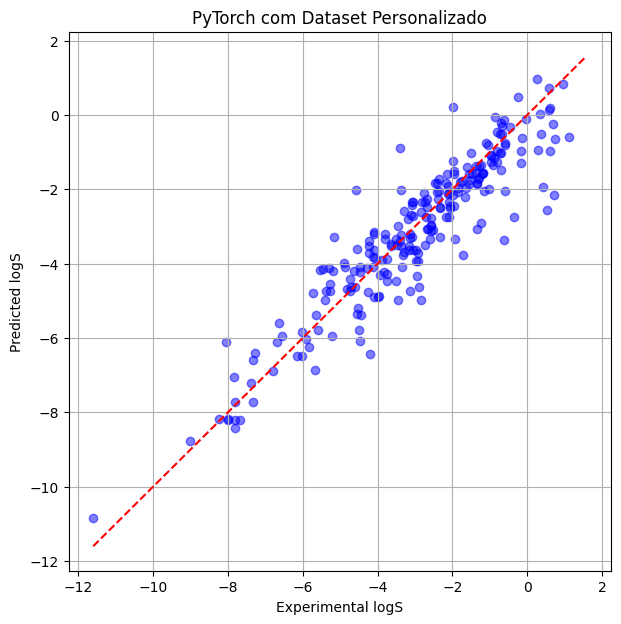

In [ ]:
# training the model
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
        
# avaluating the model
model.eval()
with torch.no_grad():
    y_test_pred = []
    y_test_true = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_test_pred.append(output)
        y_test_true.append(y_batch)

    y_test_pred = torch.cat(y_test_pred).numpy()
    y_test_true = torch.cat(y_test_true).numpy()

print("resultados do modelo:")
print("Test MSE:", mean_squared_error(y_test_true, y_test_pred))
print("Test R² :", r2_score(y_test_true, y_test_pred))

# graph
plt.figure(figsize=(7,7))
plt.scatter(y_test_true, y_test_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel('Experimental logS')
plt.ylabel('Predicted logS')
plt.title('Resultados do modelo')
plt.grid(True)
plt.show()